# Time Series Forecasting with the Long Short-Term Memory Network in Python
[Source](http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

Add the imports

In [3]:
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('./shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

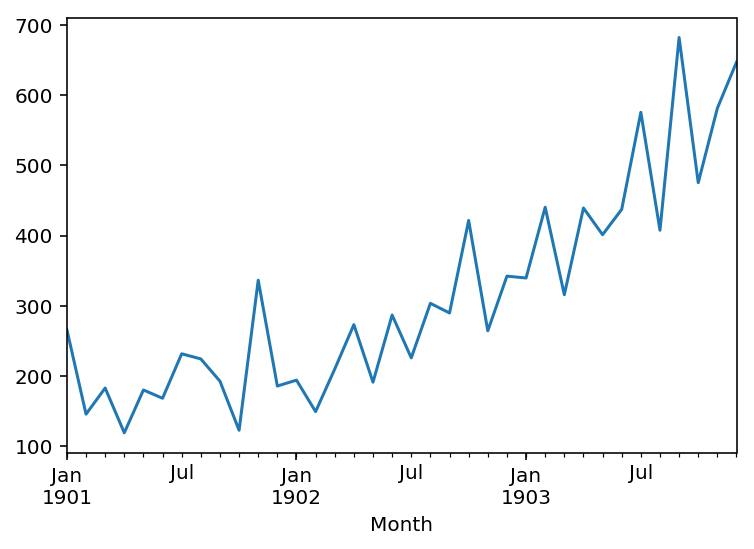

In [11]:
# line plot
series.plot();